In [ ]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from typing import List

In [ ]:
!pip install pandahouse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandahouse: filename=pandahouse-0.2.7-py2.py3-none-any.whl size=5921 sha256=d4514125f658fd0b31ee5afecc86d332ada690136f42c960a60a0a3749d2a551
  Stored in directory: /root/.cache/pip/wheels/a5/21/86/0baf87a3ad07ced200fa982d25162c82bb099114382cdeaa46
Successfully built pandahouse


In [ ]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20221020'
}

### Линеаризованный CTR для 1 и 2 групп

In [ ]:
q = """
select user_id,
exp_group, 
countIf(action='like') as likes,
countIf(action='view') as views, 
likes / views as ctr
from {db}.feed_actions
where toDate(time) >= '2022-10-03' and toDate(time) <= '2022-10-09'
and exp_group in (1, 2)
group by exp_group, user_id
"""

In [ ]:
df_12 = ph.read_clickhouse(q, connection=connection)
df_12

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,33,122,0.270492
4,18392,1,7,32,0.218750
...,...,...,...,...,...
20026,132567,1,45,296,0.152027
20027,30872,1,11,59,0.186441
20028,25383,2,42,127,0.330709
20029,139020,2,24,114,0.210526


In [ ]:
def lin_likes(user_likes: pd.Series,
              user_views: pd.Series,
              global_ctr_control: int
) -> pd.Series:
    linearized_likes = user_likes - global_ctr_control * user_views
    return linearized_likes

In [ ]:
# считаем общий CTR в контрольной группе
global_ctr_control = df_12[df_12['exp_group'] == 1]['likes'].sum() / df_12[df_12['exp_group'] == 1]['views'].sum()
global_ctr_control

0.20802680490126244

In [ ]:
linearized_likes_control = lin_likes(df_12[df_12['exp_group'] == 1]['likes'],
                                     df_12[df_12['exp_group'] == 1]['views'],
                                     global_ctr_control)

In [ ]:
linearized_likes_control

0        -0.120402
1         2.668221
2         2.814043
3         0.343142
4         7.620730
           ...    
20020    -1.361206
20021     4.069561
20024    -0.328429
20025   -16.575934
20027    -1.273581
Length: 10079, dtype: float64

In [ ]:
linearized_likes_treat = lin_likes(df_12[df_12['exp_group'] == 2]['likes'],
                                   df_12[df_12['exp_group'] == 2]['views'],
                                   global_ctr_control)

In [ ]:
linearized_likes_treat

5       -13.875592
6       -11.098332
7       -10.010707
8        -0.627431
9        21.277588
           ...    
20023    -2.120402
20026    -2.080268
20028    15.580596
20029     0.284944
20030    -8.058198
Length: 9952, dtype: float64

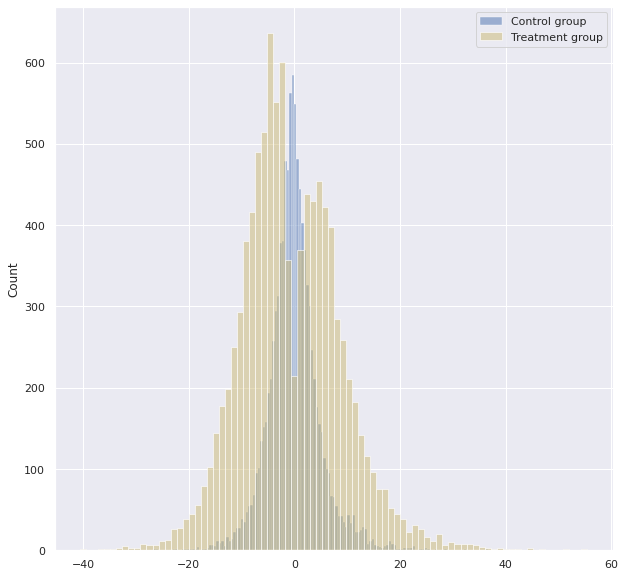

In [ ]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.histplot(linearized_likes_control,
             color='b',
             alpha=0.5,
             kde=False);
sns.histplot(linearized_likes_treat,
             color='y',
             alpha=0.5,
             kde=False);
plt.legend(labels=['Control group', 'Treatment group']);

**ttest**

In [ ]:
st.ttest_ind(linearized_likes_control,
             linearized_likes_treat,
             equal_var=False)

Ttest_indResult(statistic=6.122579994775973, pvalue=9.439432187037712e-10)

***Mann-Witney test***

In [ ]:
st.mannwhitneyu(linearized_likes_control, linearized_likes_treat, alternative='two-sided')

MannwhitneyuResult(statistic=54534537.0, pvalue=9.404319579641738e-27)

### Обычный CTR для 1 и 2 групп

In [ ]:
group_1 = df_12[df_12['exp_group'] == 1]['ctr'] # control group
group_2 = df_12[df_12['exp_group'] == 2]['ctr'] # treatment group

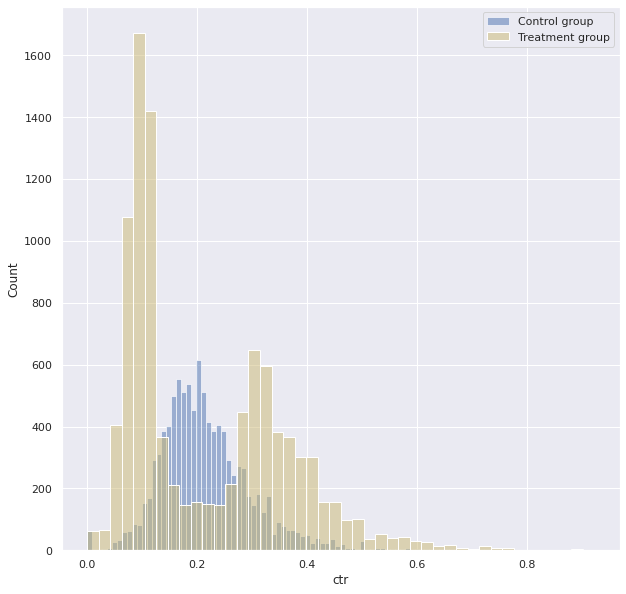

In [ ]:
sns.histplot(group_1,
             color='b',
             alpha=0.5,
             kde=False)
sns.histplot(group_2,
             color='y',
             alpha=0.5,
             kde=False)
plt.legend(labels=['Control group', 'Treatment group']);

**ttest**

In [ ]:
st.ttest_ind(group_1,
             group_2,
             equal_var=False)

Ttest_indResult(statistic=0.7094392041270651, pvalue=0.47806231308748337)

***Mann-Witney test***

In [ ]:
st.mannwhitneyu(group_1, group_2, alternative='two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

**Вывод** \

Линеаризованный ttest показывает стат. значимое различие между контрольной и тестовой группами, в отличие от обычного ttest'а. Поскольку после линеаризации распределения стали более похожими на нормальное, то применение в этом случае ttest'а корректно, и поюзерные CTR в группах действительно различаются. \
Тест Манна-Уитни так же, как и для обычного поюзерного CTR, показывает различие, но p-value увеличился. 

### Линеаризованный CTR для 0 и 3 групп



In [ ]:
q_03 = """
select user_id,
exp_group, 
countIf(action='like') as likes,
countIf(action='view') as views, 
likes / views as ctr
from {db}.feed_actions
where toDate(time) >= '2022-10-03' and toDate(time) <= '2022-10-09'
and exp_group in (0, 3)
group by exp_group, user_id
"""

In [ ]:
df_03 = ph.read_clickhouse(q_03, connection=connection)
df_03

,user_id,exp_group,likes,views,ctr
0,115383,3,9,30,0.300000
1,123580,3,13,48,0.270833
2,4944,0,8,41,0.195122
3,4504,0,5,15,0.333333
4,121508,0,18,88,0.204545
...,...,...,...,...,...
20043,13781,3,10,27,0.370370
20044,130651,3,18,98,0.183673
20045,3681,0,7,55,0.127273
20046,122008,3,5,41,0.121951


In [ ]:
global_ctr_control_0 = df_03[df_03['exp_group'] == 0]['likes'].sum() / df_03[df_03['exp_group'] == 0]['views'].sum()
global_ctr_control_0

0.20823612262916305

In [ ]:
linearized_likes_control_0 = lin_likes(df_03[df_03['exp_group'] == 0]['likes'],
                                     df_03[df_03['exp_group'] == 0]['views'],
                                     global_ctr_control)

In [ ]:
linearized_likes_control_0

2        -0.529099
3         1.879598
4        -0.306359
5         2.182606
6        -1.882949
           ...    
20038    10.868891
20039     0.854177
20040    -0.521742
20041    -0.113045
20045    -4.441474
Length: 9999, dtype: float64

In [ ]:
linearized_likes_treat_3 = lin_likes(df_03[df_03['exp_group'] == 3]['likes'],
                                   df_03[df_03['exp_group'] == 3]['views'],
                                   global_ctr_control)

In [ ]:
linearized_likes_treat_3

0         2.759196
1         3.014713
7         2.759196
9        -6.882949
10        0.332435
           ...    
20042   -11.189307
20043     4.383276
20044    -2.386627
20046    -3.529099
20047     5.478258
Length: 10049, dtype: float64

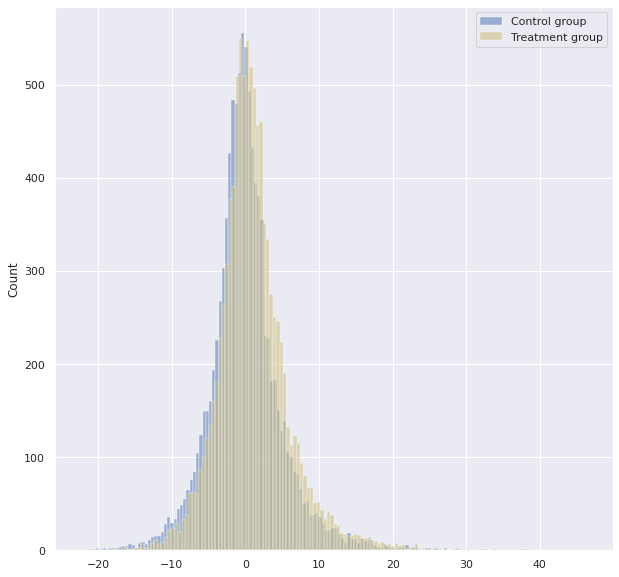

In [ ]:
sns.histplot(linearized_likes_control_0,
             color='b',
             alpha=0.5,
             kde=False);
sns.histplot(linearized_likes_treat_3,
             color='y',
             alpha=0.5,
             kde=False);
plt.legend(labels=['Control group', 'Treatment group']);

**ttest**

In [ ]:
st.ttest_ind(linearized_likes_control_0,
             linearized_likes_treat_3,
             equal_var=False)

Ttest_indResult(statistic=-15.216492682365711, pvalue=5.36858904410376e-52)

***Mann-Witney test***

In [ ]:
st.mannwhitneyu(linearized_likes_control_0, linearized_likes_treat_3, alternative='two-sided')

MannwhitneyuResult(statistic=43337306.0, pvalue=1.1042683226569279e-63)

### Обычный CTR для 0 и 3 групп

In [ ]:
group_0 = df_03[df_03['exp_group'] == 0]['ctr'] # control group
group_3 = df_03[df_03['exp_group'] == 3]['ctr'] # treatment group

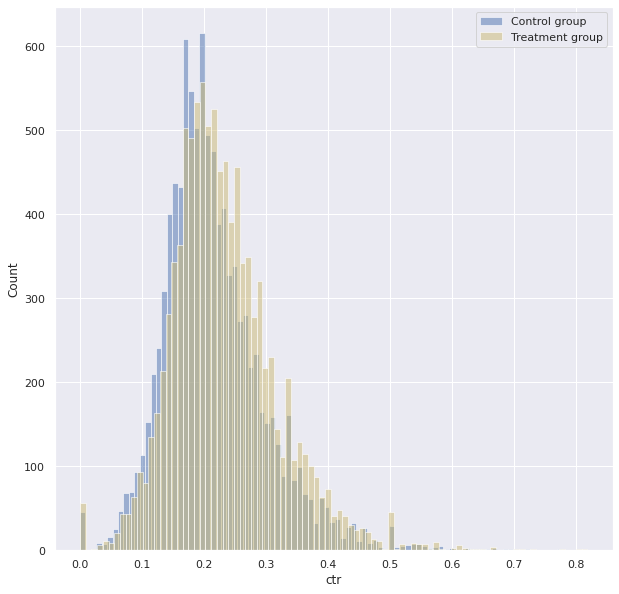

In [ ]:
sns.histplot(group_0,
             color='b',
             alpha=0.5,
             kde=False);
sns.histplot(group_3,
             color='y',
             alpha=0.5,
             kde=False);
plt.legend(labels=['Control group', 'Treatment group']);

**ttest**

In [ ]:
st.ttest_ind(group_0,
             group_3,
             equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

***Mann-Witney test***

In [ ]:
st.mannwhitneyu(group_0, group_3, alternative='two-sided')

MannwhitneyuResult(statistic=43682792.0, pvalue=1.1952055473582936e-57)

**Вывод:**

Для групп 0 и 3 все тесты показывают стат. значимое различие. В случае линеаризованной метрики p-value уменьшился.

### Заключение

Таким образом, линеаризация позволила зафиксировать стат. значимое различие на выборке, неимеющей нормальное распределение, в случае групп 1 и 2. Также линеаризация снизила p-value для ttest'а и теста Манна-Уитни в случае 0 и 3 групп.